In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.signal import chirp
from scipy.special import hyperu, laguerre, genlaguerre, hyp1f1
from scipy.constants import hbar
from scipy.constants import k as kB
from tqdm import tqdm
import dill
from scipy.integrate import quad
import qcontrol as qc

In [2]:
qargs = {
    'optical_fc':           2e9, 
    'optical_df':           0.3e9,
    'mw_fc':                1.3e9, 
    'optical_lifetime':     1/6e-9, 
    'branching_ratio':      0.0005,
    'dark_count_rate':      10e3,
    'coupling_efficiency':  0.002,
    'debye_waller_factor':  0.7,
    'non_radiative_factor': 0.5,
    't2_star' :             1.6e-6
    }
q = qc.ColorCenterQubit(**qargs)
pulses = {
    'pi' : {
        'frequency' : q.mw_fc,
        'width' : 115e-9,
        't_ramp' : 10e-9,
        'amplitude' : 30.0e6
    },
    'pi/2' : {
        'frequency' : q.mw_fc,
        'width' : 62.5e-9,
        't_ramp' : 10e-9,
        'amplitude' : 30.0e6
    },
    'readout_down' : {
        'frequency' : q.f0,
        'width' : 60e-6,
        't_ramp' : 1e-6,
        'amplitude' : 3e8
    },
    'readout_up' : {
        'frequency' : q.f1,
        'width' : 60e-6,
        't_ramp' : 1e-6,
        'amplitude' : 3e8
    }
}


phase_flags = { '_X' : 0, '_Y' : np.pi/2, '_-X' : np.pi, '_-Y' : -np.pi/2}

def process_pulse_train(t, pulse_sequence, plot=False):
    pulse_sigs = {}
    for channel, pulse_dict in pulse_sequence.items():
        pulse_sigs[channel] = np.zeros_like(t, dtype=complex)
        current_time = 0
        pulse_train = pulse_dict['pulse_train']
        for p in pulse_train:
            if isinstance(p, str):
                phase = 0
                for flag, phase_val in phase_flags.items():
                    if flag in p:
                        phase = phase_val
                        p = p.replace(flag, '')
                envelope = qc.tools.__smooth_square_pulse(None, t, current_time, pulses[p]['width'], pulses[p]['t_ramp'], pulses[p]['amplitude'])
                modulation = np.cos(2*np.pi*pulses[p]['frequency']*t+phase)
                pulse_sigs[channel] += envelope*modulation
                if plot:
                    plt.plot(t*1e6, envelope/np.max(envelope), label=f"{channel} Envelope")
                current_time += pulses[p]['width']
            else:
                current_time += p
    if plot:
        for channel, pulse_sig in pulse_sigs.items():
            plt.plot(t*1e6, pulse_sig/np.max(pulse_sig), label=channel)

        plt.legend()
        plt.xlabel('Time (us)')
        plt.ylabel('Pulse Amplitude')
        plt.title('Pulse Sequence')
        
    return pulse_sigs

def get_pulse_train_time(pulse_sequence):
    max_time = 0
    for channel, pulse_dict in pulse_sequence.items():
        current_time = 0
        pulse_train = pulse_dict['pulse_train']
        for p in pulse_train:
            if isinstance(p, str):
                phase = 0
                for flag, phase_val in phase_flags.items():
                    if flag in p:
                        phase = phase_val
                        p = p.replace(flag, '')
                current_time += pulses[p]['width']
            else:
                current_time += p
        max_time = max(max_time, current_time)
    return max_time


/home/floresh2/.conda/envs/zm/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/floresh2/.conda/envs/zm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


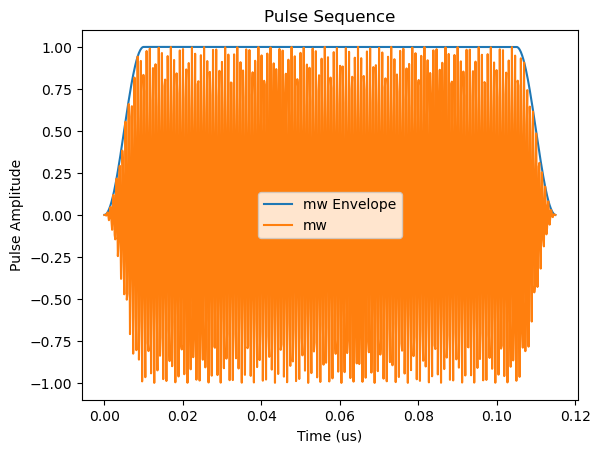

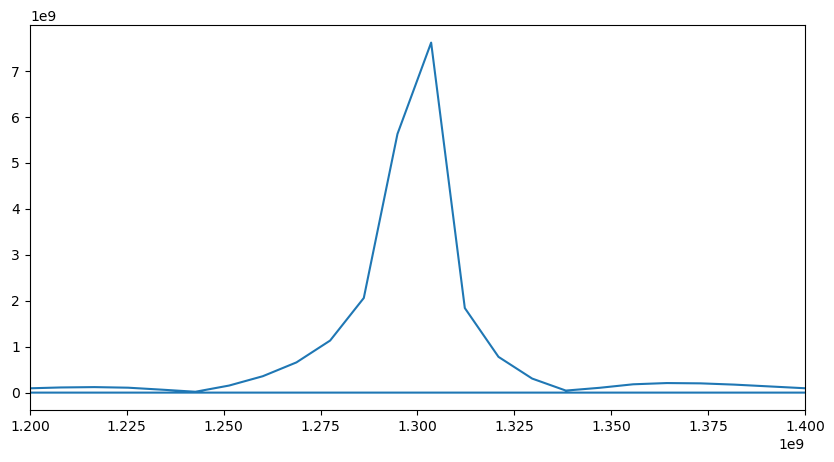

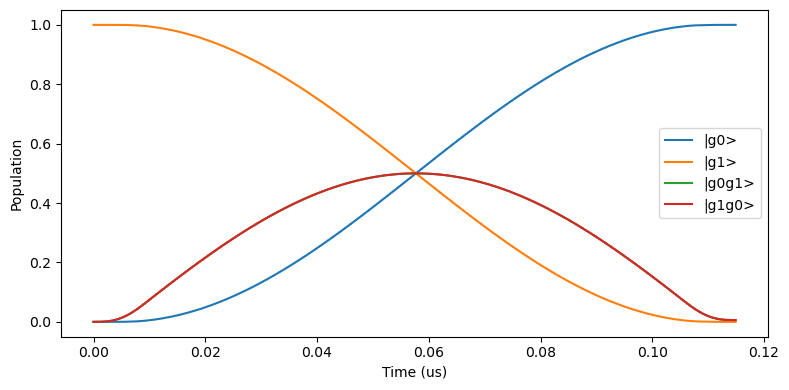

0.9999635351208128


In [3]:
qargs = {
        'optical_fc':           2e9, 
        'optical_df':           0.3e9,
        'mw_fc':                1.3e9, 
        'optical_lifetime':     1/6e-9, 
        'branching_ratio':      0.0005,
        'dark_count_rate':      10e3,
        'coupling_efficiency':  0.002,
        'debye_waller_factor':  0.7,
        'non_radiative_factor': 0.5,
        't2_star' :             6e-6,
        'memory_tau' :          1e-3,
        }
ramsey_sequence = {
    'mw' : {'pulse_train' : ['pi_X']},
    # 'optical' : {'pulse_train' : [pulses['pi/2']['width'], wait_time, pulses['pi/2']['width'], wait_time, 'readout_up']}
}
t = np.arange(0, get_pulse_train_time(ramsey_sequence), 1/6.144e9)
ramsey_sigs = process_pulse_train(t, ramsey_sequence, plot=True)
# Plot the fourier transform of the pulse
plt.figure(figsize=(10, 5))
freqs = np.fft.fftfreq(len(t), t[1]-t[0])
plt.plot(freqs, np.abs(np.fft.fft(ramsey_sigs['mw'])))
plt.xlim(1.2e9, 1.4e9)
plt.show()

# q = qc.ColorCenterQubit(**qargs)
result, _ = q.apply_pulse_sequence(t, ramsey_sigs, plot=True)
print(np.abs(result.expect[0][-1]))

  0%|          | 0/1 [00:00<?, ?it/s]

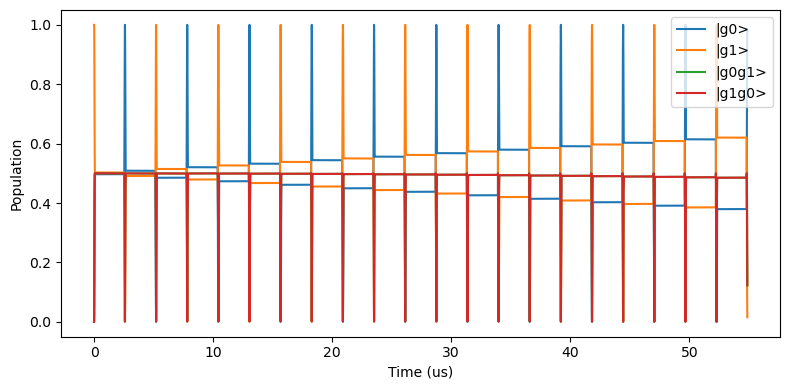

100%|██████████| 1/1 [00:13<00:00, 13.61s/it]


In [5]:

wait_times = np.linspace(5e-6, 50e-6, 1)
transfer = []
for wait_time in tqdm(wait_times):
    ramsey_flips = 20
    ramsey_sequence = {
        'mw' : {'pulse_train' : ['pi/2_X', wait_time/2-26.25e-9, 'pi_X'] + [wait_time/2, 'pi_X']*(ramsey_flips-1) + [wait_time/2-26.25e-9, 'pi/2_X']},
        # 'optical' : {'pulse_train' : [\pulses['pi/2']['width'], wait_time, pulses['pi/2']['width'], wait_time, 'readout_up']}
    }
    t = np.arange(0, get_pulse_train_time(ramsey_sequence), 1/6.144e9)
    ramsey_sigs = process_pulse_train(t, ramsey_sequence, plot=False)   
    q = qc.ColorCenterQubit(**qargs)
    result, purity_history = q.apply_pulse_sequence(t, ramsey_sigs, plot=True, use_coherence_trajectory=False, custom_options={'atol':1e-9, 'rtol':1e-9})
    